In [1]:
import cv2
import math
import copy
import pickle
import numpy as np
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from scipy.ndimage import morphology as morph
from skimage.morphology import disk

## Q1
### Part 1

In [2]:
def getMedian(arr):
  # Find position of mid element
  midElement = 1
  for el in arr:
    midElement += el
  midElement = int(midElement / 2)

  # Find prefix sum untill u get the element with prefix sum > mid
  s = 0
  for i in range(256):
    s += arr[i]
    if s >= midElement:
      return i

  # Incase of any error
  print('Some Error Occurred')
  return None

# Efficient median filter
def efficientMedianFilter(img, k):
  kby2 = int(k / 2)
  # Padding image
  img3 = np.zeros((img.shape[0] + 2 * kby2, img.shape[1] + 2 * kby2)).astype('uint8')
  img3[kby2:img3.shape[0] - kby2, kby2:img3.shape[1] - kby2] = img
  img2 = img3.copy()
  # 256 sized pixel count array
  pixelCnt = np.zeros(256, dtype=int)
  for r in range(k):
    for c in range(k):
      pixelCnt[img3[r][c]] += 1
  prevPixelArr = pixelCnt.copy()
  # Filter value of first top leftmost block
  img2[kby2][kby2] = getMedian(pixelCnt)
  # Applying convolution
  for r in range(kby2, img3.shape[0] - kby2):
    for c in range(kby2, img3.shape[1] - kby2):
      if r == kby2 and c == kby2:
        continue
      if c == kby2:
        # Add new pixels
        for i in img3[r + kby2:r + kby2 + 1, c - kby2:c + kby2 + 1][0]:
          prevPixelArr[i] += 1
        # Remove pixels that went out of the frame
        for i in img3[r - kby2 - 1:r - kby2, c - kby2:c + kby2 + 1][0]:
          prevPixelArr[i] -= 1
        img2[r][c] = getMedian(prevPixelArr)
        pixelCnt = prevPixelArr.copy()
        continue
      # Add new pixels
      for i in img3[r - kby2:r + kby2 + 1, c + kby2:c + kby2 + 1].reshape((1, k))[0]:
        pixelCnt[i] += 1
      # Remove pixels that went out of the frame
      for i in img3[r - kby2:r + kby2 + 1, c - kby2 - 1:c - kby2].reshape((1, k))[0]:
        pixelCnt[i] -= 1
      img2[r][c] = getMedian(pixelCnt)
  return np.rint(img2[kby2:img2.shape[0] - kby2, kby2:img2.shape[1] - kby2]).astype('uint8')
# Example with filter size 9 (k = 9)
img = cv2.cvtColor(cv2.imread('./../images/NoisySimba.png'), cv2.COLOR_BGR2RGB)
b, g, r = cv2.split(img)
b = efficientMedianFilter(b, 3)
g = efficientMedianFilter(g, 3)
r = efficientMedianFilter(r, 3)
imgnew = cv2.merge((r, g, b)).astype('uint8')


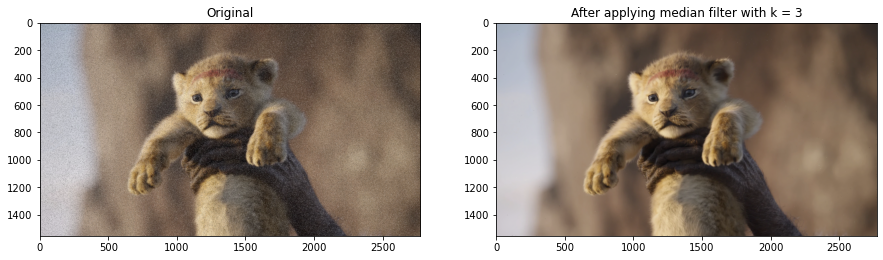

In [3]:
imgnew = cv2.cvtColor(imgnew,cv2.COLOR_BGR2RGB)
f, axarr = plt.subplots(1, 2, figsize=(15,8))
axarr[0].imshow(img)
axarr[0].title.set_text('Original')
axarr[1].imshow(imgnew)
axarr[1].title.set_text('After applying median filter with k = 3')

### Part 2

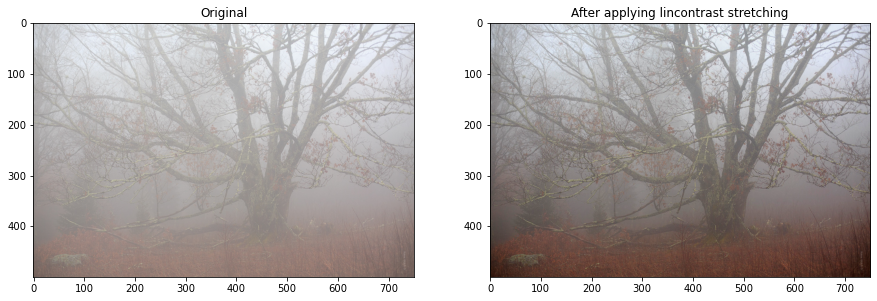

In [4]:
def linContrastStretching(im, a, b, low=0.05, high=0.95, a_min=None, a_max=None):
    imcopy = im.flat.copy()
    size_of_imcopy = len(imcopy)
    H = np.bincount(imcopy, minlength=256)
    
    # a_min = minimum intensity threshold
    if a_min == None:
        # set a_min to value with less than low percentile intensities
        a_min = min(imcopy[H[imcopy] >= size_of_imcopy*low], default=min(imcopy))
    # a_max = the maximum intensity threshold of given image
    if a_max == None:
        # set a_max to value with more than high percentile intensities
        a_max = max(imcopy[H[imcopy] <= size_of_imcopy*(high)], default=max(imcopy))

    new_img = np.zeros(im.shape)
    # map intensity range [a_min, a_max] to [a, b]
    new_img = new_img + np.rint(a + (im - a_min)*((b-a)/(a_max - a_min)))
    # set intensities <= a_min to a
    new_img = np.where(im <= a_min, a, new_img)
    # set intensities >= a_max to b
    new_img = np.where(im >= a_max, b, new_img)                                          
    return new_img.astype('uint8')
bad = cv2.imread('../images/fog.jpeg')
bad = cv2.cvtColor(bad,cv2.COLOR_BGR2RGB)
improved = np.copy(bad)
improved = linContrastStretching(improved,1,255)
f, axarr = plt.subplots(1, 2, figsize=(15,8))
axarr[0].imshow(bad)
axarr[0].title.set_text('Original')
axarr[1].imshow(improved)
axarr[1].title.set_text('After applying lincontrast stretching')

### Part 3

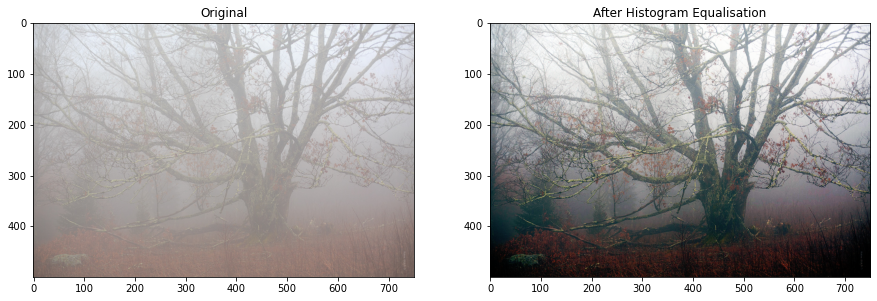

In [32]:
def getHist(im):
    # Make histogram by find the count for each pixel intensity
    histogramArr = np.array([ 0 for i in range(256) ])
    for i in im.flatten():
        histogramArr[i] += 1
    return histogramArr
# Applies histogram equalization on image 'im'
def histEqualization(im):
  # getting the histogram
    histogramArr = getHist(im)

    # Find cumulative sum
    for i in range(255):
        histogramArr[i + 1] += histogramArr[i]

    # Normalizing to make the value to be in the range [0, 255]
    arr2 = (histogramArr - histogramArr.min()) * 255    # subtract minimum value from all to make it start from 0
    N = histogramArr.max() - histogramArr.min()         # Number to divide with to make the values in arr2 be in the range [0, 255]
    histogramArr = (arr2 / N).astype('uint8')           # Dividing by N

    # Map pixels to new histogram. For a pixel with value x, it's new value becomes the value in the histogram. i.e. histogramArr[x]
    for row in range(im.shape[0]):
        for col in range(im.shape[1]):
            im[row][col] = histogramArr[im[row][col]]

    return im
bad = cv2.imread('../images/fog.jpeg')
bad1 = cv2.cvtColor(bad,cv2.COLOR_BGR2RGB)
b, g, r = cv2.split(bad)
b = histEqualization(b)
g = histEqualization(g)
r = histEqualization(r)
imgnew = cv2.merge((r, g, b)).astype('uint8')
f, axarr = plt.subplots(1,2,figsize=(15, 5))
axarr[0].imshow(bad1)
axarr[0].title.set_text('Original')
axarr[1].imshow(imgnew)
axarr[1].title.set_text('After Histogram Equalisation')
plt.show()

### Part 4

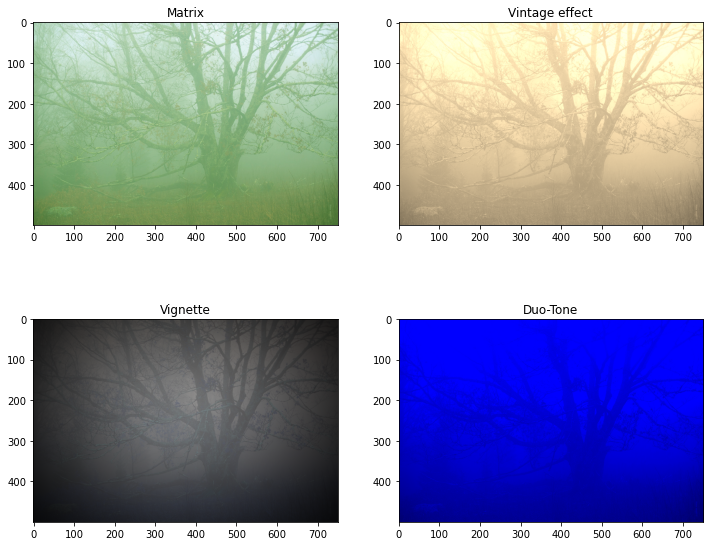

In [45]:

def vintage(im):
    im=np.array(im,dtype=np.float64)
    vin_fil=[[0.393, 0.769, 0.189],[0.349, 0.686, 0.168],[0.272, 0.543, 0.131]]
    vin_fil=np.array(vin_fil)
#     im_vin=conv_sp(vin_fil,im)
    r=np.clip(im[:,:,0]*vin_fil[0,0]+im[:,:,1]*vin_fil[0,1]+im[:,:,2]*vin_fil[0,2],0,255)
    g=np.clip(im[:,:,0]*vin_fil[1,0]+im[:,:,1]*vin_fil[1,1]+im[:,:,2]*vin_fil[1,2],0,255)
    bl=np.clip(im[:,:,0]*vin_fil[2,0]+im[:,:,1]*vin_fil[2,1]+im[:,:,2]*vin_fil[2,2],0,255)
    im[:,:,0]=r
    im[:,:,1]=g
    im[:,:,2]=bl
#     print(im)
    return im.astype(np.uint8)
def vignette(img):
    im=np.copy(img)
    h,w,d=np.shape(im)
    x_g=cv2.getGaussianKernel(w,250)
    y_g=cv2.getGaussianKernel(h,200)
#     print(x_g)
    
    ker=y_g*x_g.T
    mask=ker*255/np.linalg.norm(ker)
    im_out=np.zeros(np.shape(im))
    im_out[:,:,0]=im[:,:,2]*mask
    im_out[:,:,1]=im[:,:,1]*mask
    im_out[:,:,2]=im[:,:,0]*mask
    return np.clip(im_out,0,255).astype('int')
def matrix(img):
  row = img.shape[0]
  col = img.shape[1]
  for i in range(row):
    for j in range(col):
      img[i][j][0] = 255*((img[i][j][0]/255)**np.float(1.5))
      img[i][j][1] = 255*((img[i][j][1]/255)**np.float(0.8))
      img[i][j][2] = 255*((img[i][j][2]/255)**np.float(1.5))

  return img
def duotone(img, number):
    for i in range(3):
        if i == number:
            table = np.array([min((j**1.05), 255) for j in np.arange(0, 256)]).astype("uint8")
            img[:, :, i] = cv2.LUT(img[:,:,i], table)
        else:
            img[:, :, i] = 0 
    return img
bad = cv2.imread('../images/fog.jpeg')
bad1 = cv2.cvtColor(bad,cv2.COLOR_BGR2RGB)
bad2 = np.copy(bad1)
f, axarr = plt.subplots(2, 2, figsize=(12,10))
axarr[0][0].imshow(matrix(bad1))
axarr[0][0].title.set_text('Matrix')
bad1 = cv2.cvtColor(bad,cv2.COLOR_BGR2RGB)
axarr[0][1].imshow(vintage(bad))

axarr[0][1].title.set_text('Vintage effect')
axarr[1][0].imshow(vignette(bad2))
axarr[1][0].title.set_text('Vignette')
axarr[1][1].imshow(duotone(bad2,2))
axarr[1][1].title.set_text('Duo-Tone')


## Q2
### Part 1

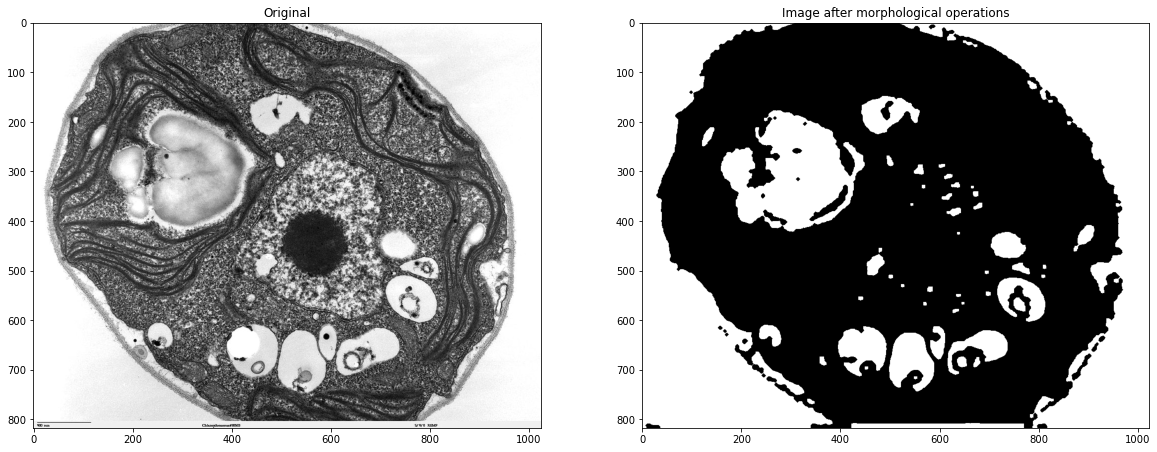

In [40]:
img = cv2.imread('./../images/cell.png', 0)
original = img.copy()
# Thresholding
_, img = cv2.threshold(img, 132, 255, cv2.THRESH_BINARY)
# Closing operation
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2)))
# Opening operation
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (12, 12)))
# Eroding with structural element for 3 iterations
img = cv2.erode(img, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations = 3)

# Plotting
f, axarr = plt.subplots(1, 2, figsize=(20,10))
axarr[0].imshow(original, cmap='gray')
axarr[0].title.set_text('Original')
axarr[1].imshow(img, cmap='gray')
axarr[1].title.set_text('Image after morphological operations')

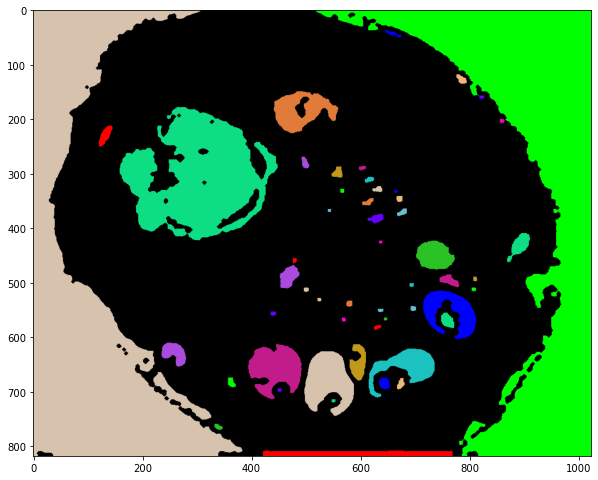

In [41]:
# Check if position of pixel is inside image and is not visited
def validate(a, b, img, vis):
  if len(img.shape) == 3:
    return not (a < 0 or a >= img.shape[0] or b < 0 or b >= img.shape[1] or (img[i][j] != img[a][b]).any() or vis[a][b] == 1)
  return not (a < 0 or a >= img.shape[0] or b < 0 or b >= img.shape[1] or img[a][b] == 0 or vis[a][b] == 1)

# BFS method to colour pixels
def BFS(x, y, c, img, vis, final_img, conn8=False):
  vis[x][y] = 1
  final_img[x][y] = colors[c]
  queue = deque([[x, y]])
  size_deque = 1
  total_pixels = 0
  while size_deque > 0:
    total_pixels += 1
    cur_pos = queue.popleft()
    size_deque -= 1
    if conn8:
      # 8 connectivity
      for i in range(-1, 2):
        for j in range(-1, 2):
          if (i != 0 or j != 0) and validate(cur_pos[0] + i, cur_pos[1] + j, img, vis):
            vis[cur_pos[0] + i][cur_pos[1] + j] = 1
            final_img[cur_pos[0] + i][cur_pos[1] + j] = colors[c]
            queue.append([cur_pos[0] + i, cur_pos[1] + j])
            size_deque += 1
    else:
      # 4 - connectivity
      # Bottom pixel
      if validate(cur_pos[0] + 1, cur_pos[1], img, vis):
        vis[cur_pos[0] + 1][cur_pos[1]] = 1
        final_img[cur_pos[0] + 1][cur_pos[1]] = colors[c]
        queue.append([cur_pos[0] + 1, cur_pos[1]])
        size_deque += 1
      # Top pixel
      if validate(cur_pos[0] - 1, cur_pos[1], img, vis):
        vis[cur_pos[0] - 1][cur_pos[1]] = 1
        final_img[cur_pos[0] - 1][cur_pos[1]] = colors[c]
        queue.append([cur_pos[0] - 1, cur_pos[1]])
        size_deque += 1
      # Right pixel
      if validate(cur_pos[0], cur_pos[1] + 1, img, vis):
        vis[cur_pos[0]][cur_pos[1] + 1] = 1
        final_img[cur_pos[0]][cur_pos[1] + 1] = colors[c]
        queue.append([cur_pos[0], cur_pos[1] + 1])
        size_deque += 1
      # Left pixel
      if validate(cur_pos[0], cur_pos[1] - 1, img, vis):
        vis[cur_pos[0]][cur_pos[1] - 1] = 1
        final_img[cur_pos[0]][cur_pos[1] - 1] = colors[c]
        queue.append([cur_pos[0], cur_pos[1] - 1])
        size_deque += 1
  # Return total number of pixels in the connected component
  return total_pixels
final_img = np.zeros((img.shape[0], img.shape[1], 3)).astype('uint8')
# Visited array to keep track of visited pixels
vis = np.zeros(img.shape)
# Colours to use for marking connected components
colors = [[215, 194, 174], [0, 255, 0], [0, 0, 255], [237, 184, 121],
          [224, 123, 57], [105, 189, 210], [105, 189, 210], [101, 0, 255],
          [13, 222, 132], [255, 0, 203], [42, 194, 37], [255, 0, 0],
          [168, 75, 222], [194, 27, 138], [194, 152, 27], [27, 194, 191],[215, 194, 174], [0, 255, 0], [0, 0, 255], [237, 184, 121],
          [224, 123, 57], [105, 189, 210], [105, 189, 210], [101, 0, 255],
          [13, 222, 132], [255, 0, 203], [42, 194, 37], [255, 0, 0],
          [168, 75, 222], [194, 27, 138], [194, 152, 27], [27, 194, 191],[215, 194, 174], [0, 255, 0], [0, 0, 255], [237, 184, 121],
          [224, 123, 57], [105, 189, 210], [105, 189, 210], [101, 0, 255],
          [13, 222, 132], [255, 0, 203], [42, 194, 37], [255, 0, 0],
          [168, 75, 222], [194, 27, 138], [194, 152, 27], [27, 194, 191],[215, 194, 174], [0, 255, 0], [0, 0, 255], [237, 184, 121],
          [224, 123, 57], [105, 189, 210], [105, 189, 210], [101, 0, 255],
          [13, 222, 132], [255, 0, 203], [42, 194, 37], [255, 0, 0],
          [168, 75, 222], [194, 27, 138], [194, 152, 27], [27, 194, 191]]
colors = np.array(colors)
color = -1
# Color pixels (Find connected components)
for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    if img[i][j] != 0 and vis[i][j] == 0:
      color += 1
      BFS(i, j, color, img, vis, final_img)
plt.figure(figsize=(10, 10))
plt.imshow(final_img)

### Part 2.1

In [48]:

img = cv2.imread('./../images/objects.png', 0)
# Thresholding
_, img = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)

# Checks if holes are present in the CC with (x, y) as one of its fg pixels
def holesPresent(x, y, img, vis):
  # Mark object
  final_img = np.zeros(img.shape).astype('uint8')
  BFS(x, y, 0, img, vis, final_img)
  # Image of object with holes
  img1 = final_img.copy()
  # Image of object without holes
  img2 = final_img.copy()
  # Removing holes from second image by performing closing operation
  img2 = cv2.dilate(img2, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations = 2)
  img2 = cv2.erode(img2, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations = 2)
  # Image of holes in object
  holesImg = (img2 - img1).astype('uint8')
  vis2 = np.zeros(img.shape)
  holes = 0
  for i in range(holesImg.shape[0]):
    for j in range(holesImg.shape[1]):
      if holesImg[i][j] != 0 and vis2[i][j] == 0:
        holes += 1
        BFS(i, j, 0, holesImg, vis2, final_img)
  return holes > 0
# Visited array to keep track of visited pixels
vis = np.zeros(img.shape)
colors = np.array([1])
object_with_holes = 0
# BFS
for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    if img[i][j] != 0 and vis[i][j] == 0:
      object_with_holes += holesPresent(i, j, img, vis)

print('Number of objects with holes = ' + str(object_with_holes))

Number of objects with holes = 6


#### For each object we make another image with only that object and it's holes filled. This can be achieved by using the closing operation. Then we find the number of connected components (which will be the holes) in the image $Filled - noFilled$ to find out if the object has holes or not.

### Part 2.2

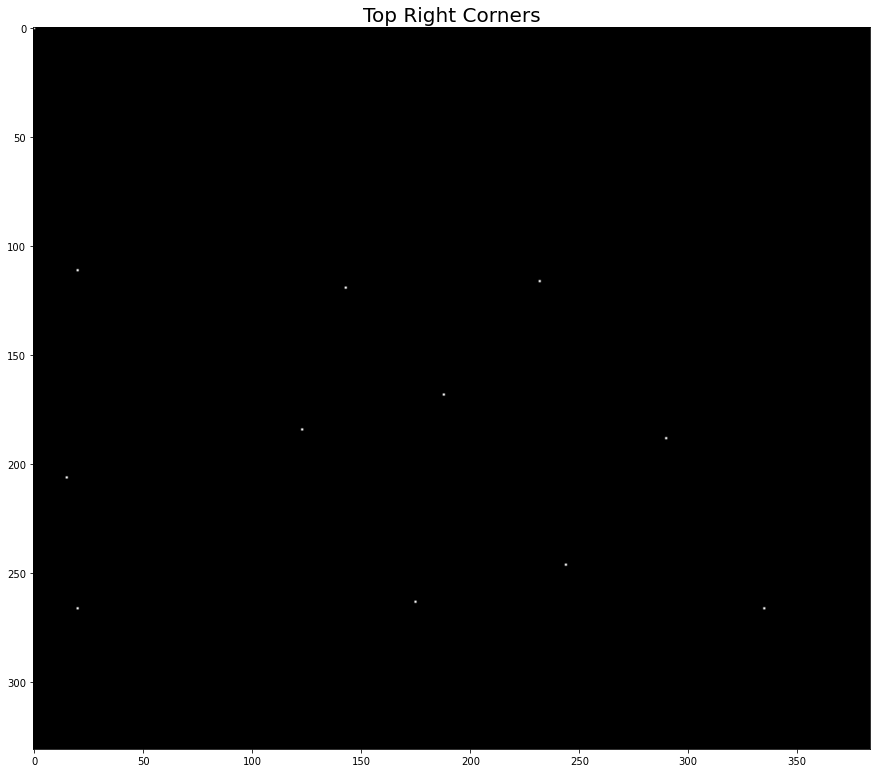

In [49]:
kernel = np.zeros((4,4),np.uint8)
for i in range(1, 4):
    kernel[1][i] = 1
    kernel[i][1] = 1

# Applying erosion with top right corner kernel
newimg = cv2.erode(img, kernel, iterations = 1)
newimg = cv2.erode(abs(newimg - img), kernel, iterations = 1)

plt.figure(figsize=(15, 15))
plt.title('Top Right Corners', fontsize = 20)
plt.imshow(newimg, cmap='gray')

#### After eroding with the kernel as used above, the top and right edges of the objects will shrink by a small amount. Then we take difference of this with original to get image with this edges. After applying erosion with the same kernel, we get the corner locations, since only they satisfy the kernel. We count these using CC algo to get count of squares.

In [50]:
final_img = np.zeros(newimg.shape).astype('uint8')
# Visited array to keep track of visited pixels
vis = np.zeros(newimg.shape)
# Colours to use for marking connected components
colors = np.array([0])
# Find number of squares i.e. corners
sqrs = 0
for i in range(1, newimg.shape[0]):
  for j in range(1, newimg.shape[1]):
    if newimg[i][j] != 0 and vis[i][j] == 0:
      sqrs += 1
      BFS(i, j, 0, newimg, vis, final_img)

print('Number of square objects in image = ' + str(sqrs))

Number of square objects in image = 11


### Part 2.3

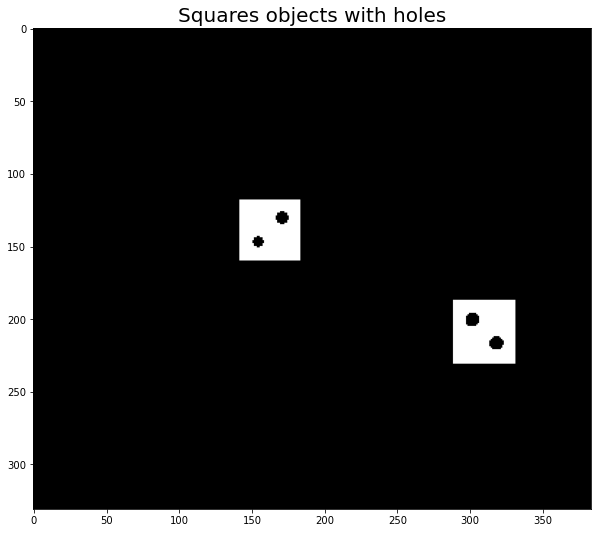

In [51]:
final_img = np.zeros(img.shape).astype('uint8')
# Visited array to keep track of visited pixels
vis = np.zeros(img.shape)
vis2 = np.zeros(img.shape)
colors = np.array([1])
# BFS
for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    if img[i][j] != 0 and vis[i][j] == 0 and newimg[i][j] != 0:
      if holesPresent(i, j, img, vis):
        BFS(i, j, 0, img, vis2, final_img)

plt.figure(figsize=(10, 10))
plt.title('Squares objects with holes', fontsize = 20)
plt.imshow(final_img, cmap='gray')

### part 3.4

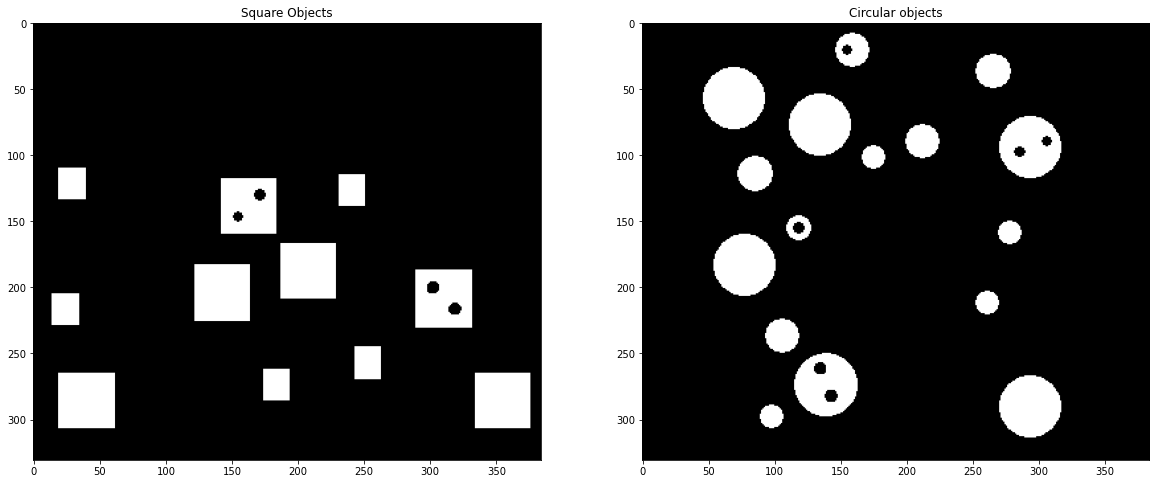

In [52]:
sqrImg = np.zeros(img.shape).astype('uint8')
# Visited array to keep track of visited pixels
vis = np.zeros(img.shape)
vis2 = np.zeros(img.shape)
colors = np.array([1])
# BFS
for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    if img[i][j] != 0 and vis[i][j] == 0 and newimg[i][j] != 0:
      BFS(i, j, 0, img, vis, sqrImg)

# Plotting
f, axarr = plt.subplots(1, 2, figsize=(20,10))
axarr[0].imshow(sqrImg, cmap='gray')
axarr[0].title.set_text('Square Objects')
circImg = img - sqrImg
axarr[1].imshow(circImg, cmap='gray')
axarr[1].title.set_text('Circular objects')

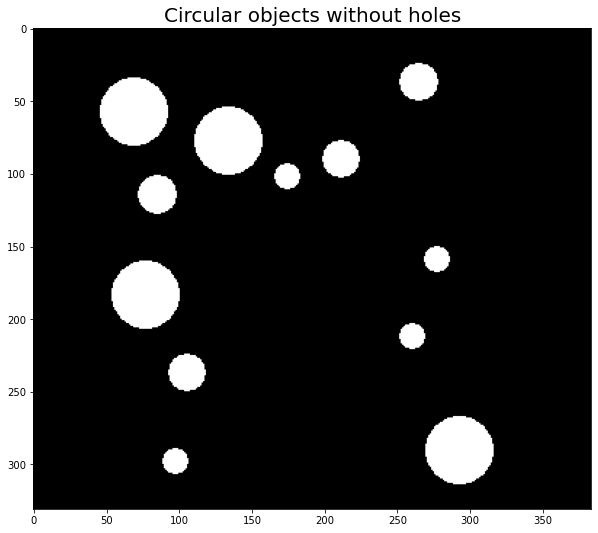

In [55]:
final_img = np.zeros(circImg.shape).astype('uint8')
# Visited array to keep track of visited pixels
vis = np.zeros(circImg.shape)
vis2 = np.zeros(circImg.shape)
colors = np.array([1])
# BFS to mark circles without any holes
for i in range(circImg.shape[0]):
  for j in range(circImg.shape[1]):
    if circImg[i][j] != 0 and vis[i][j] == 0:
      if not holesPresent(i, j, circImg, vis):
        BFS(i, j, 0, circImg, vis2, final_img)

plt.figure(figsize=(10, 10))
plt.title('Circular objects without holes', fontsize = 20)
plt.imshow(final_img, cmap='gray')

### Part 3.1

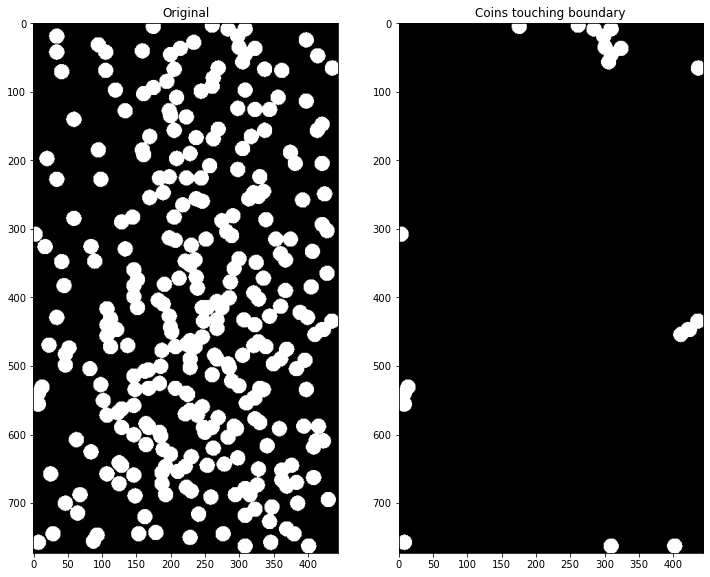

In [42]:
img = cv2.imread('./../images/circles.jpg', 0)
original = img.copy()
# Thresholding
_, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

final_img = np.zeros(img.shape).astype('uint8')
# Visited array to keep track of visited pixels
vis = np.zeros(img.shape)
# Colours to use for marking connected components
colors = np.array([255])
# Color CC on boundary, i.e. run bfs on boundary pixels
for i in range(img.shape[0]):
  if img[i][0] != 0 and vis[i][0] == 0:
    BFS(i, 0, 0, img, vis, final_img)
for i in range(img.shape[0]):
  if img[i][img.shape[1] - 1] != 0 and vis[i][img.shape[1] - 1] == 0:
    BFS(i, img.shape[1] - 1, 0, img, vis, final_img)
for i in range(img.shape[1]):
  if img[0][i] != 0 and vis[0][i] == 0:
    BFS(0, i, 0, img, vis, final_img)
for i in range(img.shape[1]):
  if img[img.shape[0] - 1][i] != 0 and vis[img.shape[0] - 1][i] == 0:
    BFS(img.shape[0] - 1, i, 0, img, vis, final_img)

# Plotting
f, axarr = plt.subplots(1, 2, figsize=(12,10))
axarr[0].imshow(original, cmap='gray')
axarr[0].title.set_text('Original')
axarr[1].imshow(final_img, cmap='gray')
axarr[1].title.set_text('Coins touching boundary')

### Part 3.2

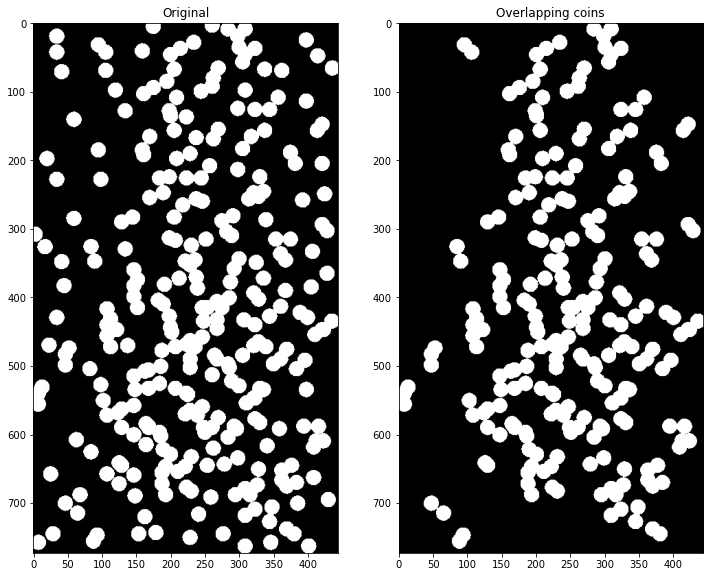

In [44]:
img = cv2.imread('./../images/circles.jpg', 0)
original = img.copy()
# Thresholding
_, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

final_img = np.zeros(img.shape).astype('uint8')
# Visited array to keep track of visited pixels
vis = np.zeros(img.shape)
# Visited array helper array to remove non overlapping components
vis2 = np.zeros(img.shape)
# Colours to use for marking connected components
colors = np.array([255, 0])
# Color CC if total pixels is greater than 420
for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    if img[i][j] != 0 and vis[i][j] == 0:
      tot_pixels = BFS(i, j, 0, img, vis, final_img)
      if tot_pixels <= 420:
        BFS(i, j, 1, img, vis2, final_img)

# Plotting
f, axarr = plt.subplots(1, 2, figsize=(12,10))
axarr[0].imshow(original, cmap='gray')
axarr[0].title.set_text('Original')
axarr[1].imshow(final_img, cmap='gray')
axarr[1].title.set_text('Overlapping coins')

### Part 3.3

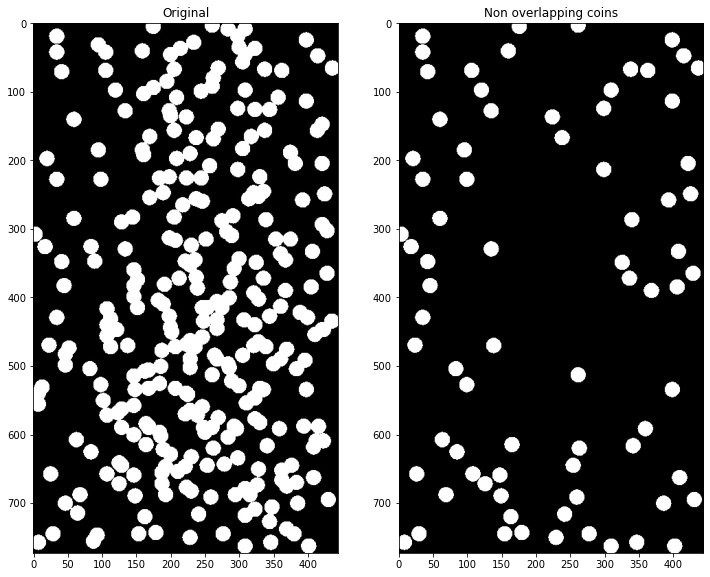

In [45]:
img = cv2.imread('./../images/circles.jpg', 0)
original = img.copy()
# Thresholding
_, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

final_img = np.zeros(img.shape).astype('uint8')
# Visited array to keep track of visited pixels
vis = np.zeros(img.shape)
# Visited array helper array to remove overlapping components
vis2 = np.zeros(img.shape)
# Colours to use for marking connected components
colors = np.array([255, 0])
# Color CC if total pixels is greater than 420
for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    if img[i][j] != 0 and vis[i][j] == 0:
      tot_pixels = BFS(i, j, 0, img, vis, final_img)
      if tot_pixels > 420:
        BFS(i, j, 1, img, vis2, final_img)

# Plotting
f, axarr = plt.subplots(1, 2, figsize=(12,10))
axarr[0].imshow(original, cmap='gray')
axarr[0].title.set_text('Original')
axarr[1].imshow(final_img, cmap='gray')
axarr[1].title.set_text('Non overlapping coins')

## Q3
### Part 1.1

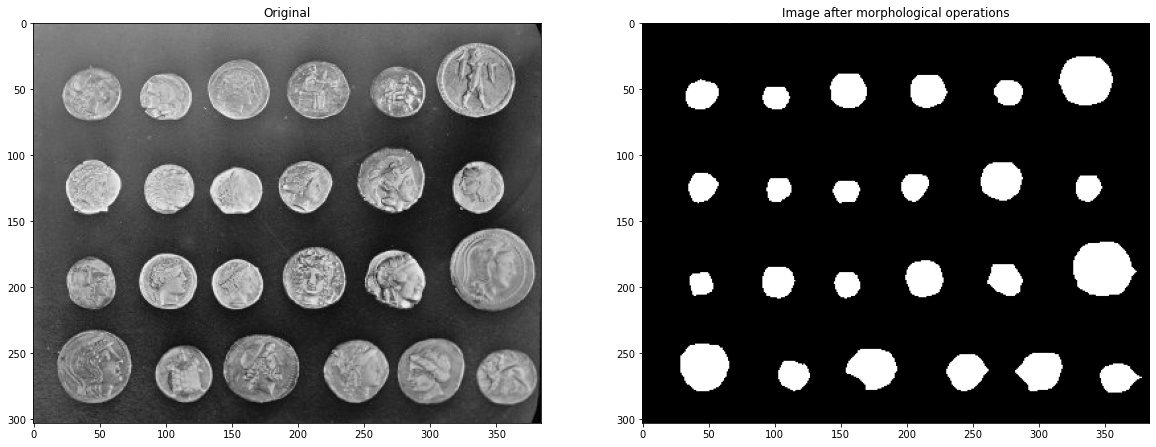

In [7]:
img = cv2.imread('./../images/coins.png', 0)
original = img.copy()
# Thresholding
_, img = cv2.threshold(img, 132, 255, cv2.THRESH_BINARY)
# Closing operation
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10)))
# Opening operation
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)))
# Eroding with structural element for 3 iterations
img = cv2.erode(img, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)), iterations = 3)

# Plotting
f, axarr = plt.subplots(1, 2, figsize=(20,10))
axarr[0].imshow(original, cmap='gray')
axarr[0].title.set_text('Original')
axarr[1].imshow(img, cmap='gray')
axarr[1].title.set_text('Image after morphological operations')

In [85]:
def countcoins(img):
  vis = np.zeros(img.shape)
  output = np.zeros(img.shape)
  sqrs=0
  for i in range(1, img.shape[0]):
    for j in range(1, img.shape[1]):
      if img[i][j] != 0 and vis[i][j] == 0:
        sqrs += 1
        BFS(i, j, 0, img, vis, output)
  print(f'There are {sqrs} coins')
countcoins(img)


There are 24 coins


### part 1.2

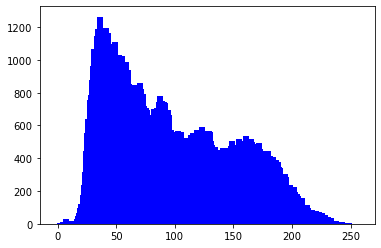

<ipython-input-8-bc7e84223f36>:52: RuntimeWarning: invalid value encountered in double_scalars
  return m/float(w)


Optimal threshold is 108


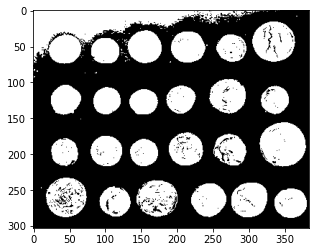

In [8]:
import math
threshold_values = {}
h = [1]


def Hist(img):
   row, col = img.shape 
   y = np.zeros(256)
   for i in range(0,row):
      for j in range(0,col):
         y[img[i,j]] += 1
   x = np.arange(0,256)
   plt.bar(x, y, color='b', width=5, align='center')
   plt.show()
   return y


def regenerate_img(img, threshold):
    row, col = img.shape 
    y = np.zeros((row, col))
    for i in range(0,row):
        for j in range(0,col):
            if img[i,j] >= threshold:
                y[i,j] = 255
            else:
                y[i,j] = 0
    return y


   
def countPixel(h):
    cnt = 0
    for i in range(0, len(h)):
        if h[i]>0:
           cnt += h[i]
    return cnt


def wieght(s, e):
    w = 0
    for i in range(s, e):
        w += h[i]
    return w


def mean(s, e):
    m = 0
    w = wieght(s, e)
    for i in range(s, e):
        m += h[i] * i
    
    return m/float(w)


def variance(s, e):
    v = 0
    m = mean(s, e)
    w = wieght(s, e)
    for i in range(s, e):
        v += ((i - m) **2) * h[i]
    v /= w
    return v
            

def threshold(h):
    cnt = countPixel(h)
    for i in range(1, len(h)):
        vb = variance(0, i)
        wb = wieght(0, i) / float(cnt)
        mb = mean(0, i)
        
        vf = variance(i, len(h))
        wf = wieght(i, len(h)) / float(cnt)
        mf = mean(i, len(h))
        
        V2w = wb * (vb) + wf * (vf)
        V2b = wb * wf * (mb - mf)**2
        
        if not math.isnan(V2w):
            threshold_values[i] = V2w


def get_optimal_threshold():
    min_V2w = min(threshold_values.values())
    optimal_threshold = [k for k, v in threshold_values.items() if v == min_V2w]
    print('Optimal threshold is', optimal_threshold[0])
    return optimal_threshold[0]


img = cv2.imread('../images/coins.png',0)

h = Hist(img)
threshold(h)
op_thres = get_optimal_threshold()

res = regenerate_img(img, op_thres)
plt.imshow(res,cmap="gray")

There are 24 coins


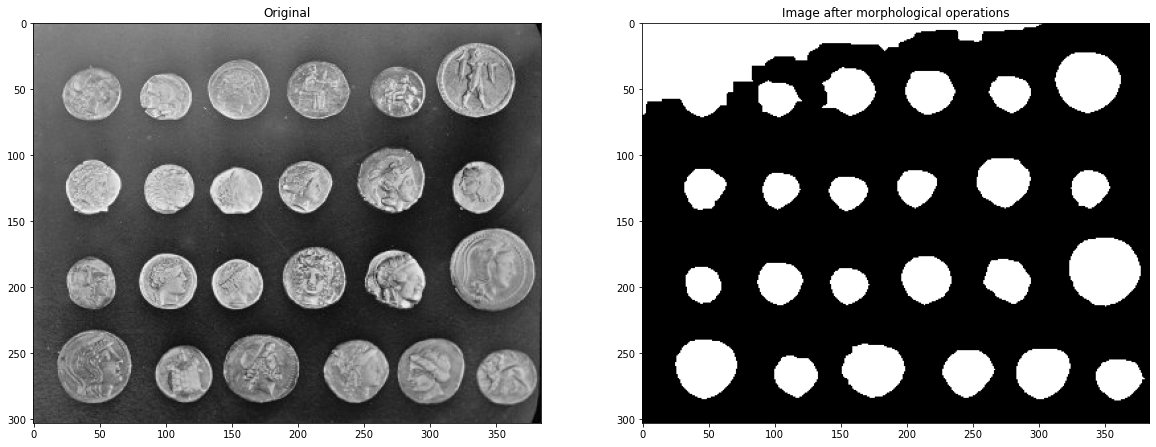

In [102]:
img = cv2.morphologyEx(res, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6)))

img = cv2.erode(img, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4)), iterations = 3)

f, axarr = plt.subplots(1, 2, figsize=(20,10))
axarr[0].imshow(original, cmap='gray')
axarr[0].title.set_text('Original')
axarr[1].imshow(img, cmap='gray')
axarr[1].title.set_text('Image after morphological operations')
def countcoins(img):
  vis = np.zeros(img.shape)
  output = np.zeros(img.shape)
  sqrs=0
  for i in range(1, img.shape[0]):
    for j in range(1, img.shape[1]):
      if img[i][j] != 0 and vis[i][j] == 0:
        sqrs += 1
        BFS(i, j, 0, img, vis, output)
  print(f'There are {sqrs} coins')
countcoins(img)

(303, 384)


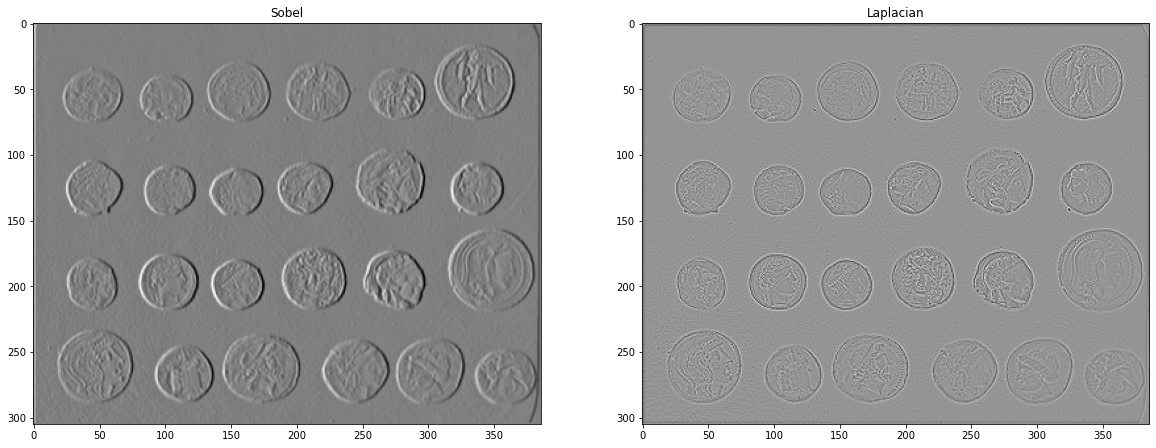

In [14]:
import math
def conv(image, k, kernel):
    if(k%2==0):
        t=math.floor(k/2)
        image = np.pad(image,((t-1,t-1),(t-1,t-1)),'constant')
    else:
        t=math.floor(k/2)
        image = np.pad(image,((t,t),(t,t)),'constant')
    out = np.zeros(image.shape)
#     print(image.shape)
    for i in range(t,image.shape[0]-t):
        for j in range(t,image.shape[1]-t):
            if(k%2==1):
                temp = image[i-t:i+t+1,j-t:j+t+1]    
            else:
                temp = image[i-(k-1)//2:i+t+1, j-(k-1)//2:j+t+1]
            out[i][j] = np.vdot(temp, kernel)
    return out


prewitt = [[[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]],[[1, 1, 1], [0, 0, 0], [-1, -1, -1]]] 
sobel = [[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]],[[1, 2, 1], [0, 0, 0], [-1, -2, -1]]]
laplacian1 = [[[0, 1, 0], [1, -4, 1], [0, 1, 0]]]
laplacian2 = [[[1, 1, 1], [1, -8, 1], [1, 1, 1]]]

print(original.shape)
sobel1 = conv(original,3,sobel[0])
laplacian1 = conv(original,3,laplacian1[0])
f, axarr = plt.subplots(1, 2, figsize=(20,10))
axarr[0].imshow(sobel1, cmap='gray')
axarr[0].title.set_text('Sobel')
axarr[1].imshow(laplacian1, cmap='gray')
axarr[1].title.set_text('Laplacian')

    

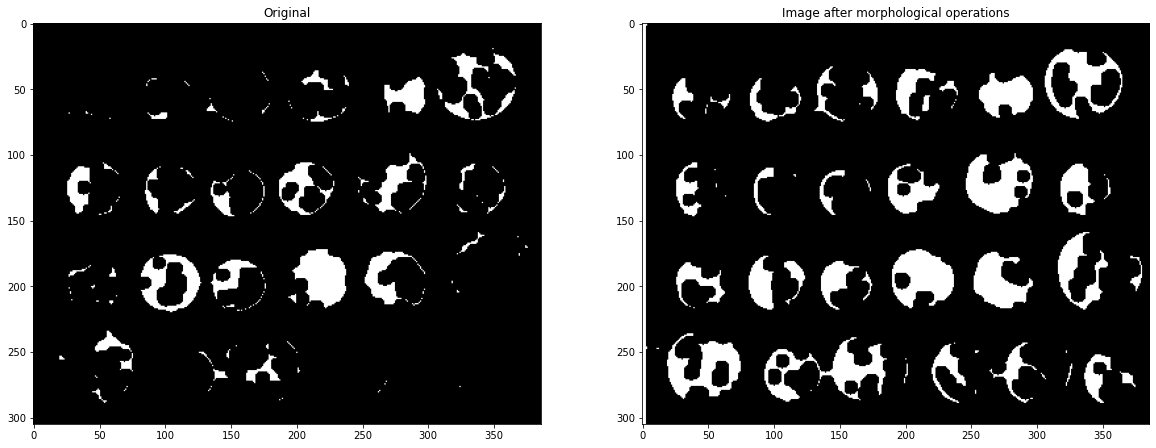

In [26]:
# Thresholding
_, img = cv2.threshold(sobel1, 132, 255, cv2.THRESH_BINARY)
_, img2 = cv2.threshold(laplacian1, 132, 255, cv2.THRESH_BINARY)
# Closing operation
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10)))
img2 = cv2.morphologyEx(img2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10)))

# Eroding with structural element for 3 iterations
# img = cv2.erode(img, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2)), iterations = 3)

# Plotting
f, axarr = plt.subplots(1, 2, figsize=(20,10))
axarr[0].imshow(img2, cmap='gray')
axarr[0].title.set_text('Original')
axarr[1].imshow(img, cmap='gray')
axarr[1].title.set_text('Image after morphological operations')

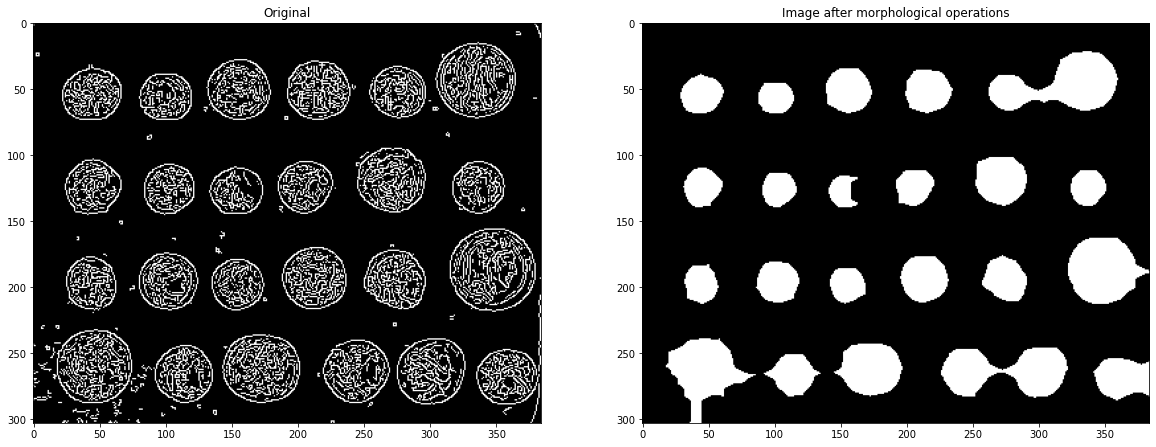

In [33]:
edges = cv2.Canny(original,60,100)
img = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10)))
img = cv2.erode(img, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations = 3)

# Plotting
f, axarr = plt.subplots(1, 2, figsize=(20,10))
axarr[0].imshow(edges, cmap='gray')
axarr[0].title.set_text('Original')
axarr[1].imshow(img, cmap='gray')
axarr[1].title.set_text('Image after morphological operations')

## Q4
### Part 1

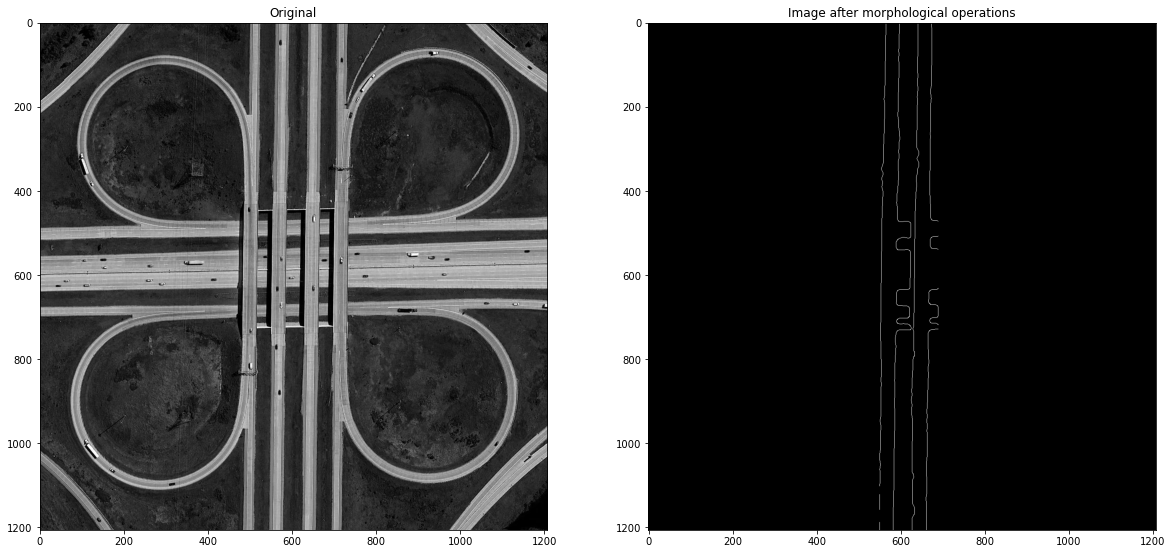

In [5]:
roads = cv2.imread("../images/roads.jpg",0)
road_copy = np.copy(roads)


_, roads = cv2.threshold(roads, 120, 255, cv2.THRESH_BINARY)
            
kernel1 = np.ones((2,2),np.uint8)
kernel2 = np.ones((4,4),np.uint8)
kernel3 = np.ones((2,2),np.uint8)
roads = cv2.dilate(roads,kernel1,iterations = 3)
roads = cv2.erode(roads,kernel2,iterations = 2)
roads = cv2.dilate(roads,kernel3,iterations = 5)
roads = cv2.medianBlur(roads,11)

edges = cv2.Canny(roads,50,100)
image = np.zeros(edges.shape)
image[:,550:690] = edges[:,550:690]
f, axarr = plt.subplots(1, 2, figsize=(20,10))
axarr[0].imshow(road_copy, cmap='gray')
axarr[0].title.set_text('Original')
axarr[1].imshow(image, cmap='gray')
axarr[1].title.set_text('Image after morphological operations')

### Part 2

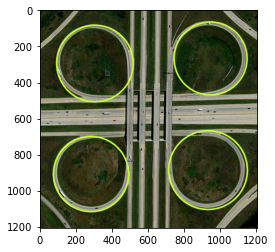

In [23]:
roads = cv2.imread("../images/roads.jpg",0)
_, roads = cv2.threshold(roads, 125, 255, cv2.THRESH_BINARY)
            
kernel = np.ones((2,2),np.uint8)
roads = cv2.dilate(roads,kernel,iterations = 3)

kernel = np.ones((4,4),np.uint8)
roads = cv2.erode(roads,kernel,iterations = 2)

kernel = np.ones((2,2),np.uint8)
roads = cv2.dilate(roads,kernel,iterations = 8)

roads = cv2.medianBlur(roads,7)
image = roads.copy()
image = 255- image
# output = roads.copy()
output = cv2.imread("../images/roads.jpg")
circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 100,
                          param1=50, param2=30, minRadius=200, maxRadius=500)
detected_circles = np.uint16(np.around(circles))
color = (255, 0, 0)

for (x, y ,r) in detected_circles[0, :]:
    cv2.circle(output, (x, y), r, (50, 255, 200), 7)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.show()

## Q5
### Part 1

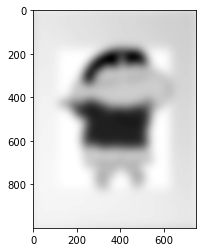

In [26]:
def psf(img, sigma):
  row,col = img.shape
  center = (row/2,col/2)
  mask = np.zeros((row,col), dtype=np.float32)
  for i in range(row):
      for j in range(col):
          x1 = 2*np.pi*(sigma**2)
          x2 = np.exp(-(i**2 + j**2)/(2* sigma**2))
          mask[i][j]=(1/x1)*x2
  return mask
img = cv2.cvtColor(cv2.imread('../images/shinchan_blur.png'), cv2.COLOR_BGR2GRAY)
plt.imshow(img,cmap='gray')
plt.show()

### Part 2/3/4

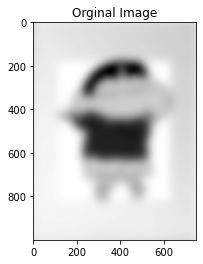

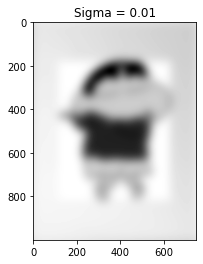

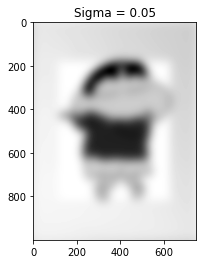

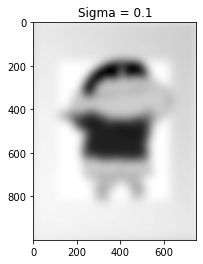

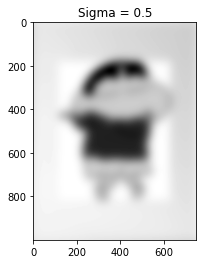

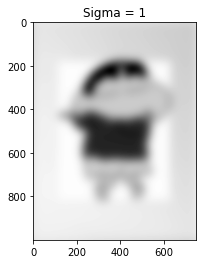

In [27]:
def deblur(sigma):
    img1 = np.float32(img)/255
    
    psf_mask = psf(img1, sigma)
    
    img_fft1 = np.fft.fft2(img1)
    img_fft = np.fft.fftshift(img_fft1)

    psf_fft1 = np.fft.fft2(psf_mask)
    psf_fft = np.fft.fftshift(psf_fft1)

    res = img_fft/psf_fft

    out1 =  np.fft.ifftshift(res)
    out = np.fft.ifft2(out1).real
    
    return out
s = [0.01, 0.05, 0.1, 0.5, 1]
plt.imshow(img, cmap='gray')
plt.title("Orginal Image")

plt.show()
for i in range(len(s)):
    output = deblur(s[i])
    plt.imshow(output, cmap = 'gray')
    plt.title("Sigma = " + str(s[i]) )
    plt.show()

## Q6
### Part 1

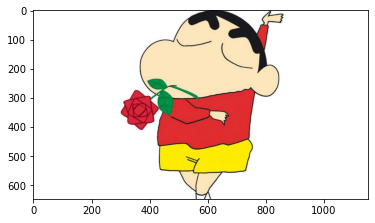

[747145, '[', 2784222, '2', 4831987, '5', 2985983, ',', 2985983, ' ', 747145, ']', 205271, '4', 232935, '3', 109114, '0', 185703, '1', 39892, '9', 51790, '7', 209610, '8', 44320, '6']


In [16]:
from ast import literal_eval
with open('../images/shinchan.pkl', 'rb') as f:
    my_string = pickle.load(f)

my_string = np.array(literal_eval(my_string))
plt.imshow(my_string)
plt.show()
a = my_string
my_string=str(my_string.tolist())
letters = []
only_letters = []

for letter in my_string:
    if letter not in letters:
        frequency = my_string.count(letter)             #frequency of each letter repetition
        letters.append(frequency)
        letters.append(letter)
        only_letters.append(letter)
        
print(letters)

### Part 1.2

In [17]:
nodes = []
while len(letters) > 0:
    nodes.append(letters[0:2])
    letters = letters[2:]                               # sorting according to frequency
nodes.sort()
print(nodes)
huffman_tree = []
huffman_tree.append(nodes) 

def combine_nodes(nodes):
    pos = 0
    newnode = []
    if len(nodes) > 1:
        nodes.sort()
        nodes[pos].append("1")                       # assigning values 1 and 0
        nodes[pos+1].append("0")
        combined_node1 = (nodes[pos] [0] + nodes[pos+1] [0])
        combined_node2 = (nodes[pos] [1] + nodes[pos+1] [1])  # combining the nodes to generate pathways
        newnode.append(combined_node1)
        newnode.append(combined_node2)
        newnodes=[]
        newnodes.append(newnode)
        newnodes = newnodes + nodes[2:]
        nodes = newnodes
        huffman_tree.append(nodes)
        combine_nodes(nodes)
    return huffman_tree                                     # huffman tree generation

newnodes = combine_nodes(nodes)
huffman_tree.sort(reverse = True)
print(huffman_tree)
checklist = []
for level in huffman_tree:
    for node in level:
        if node not in checklist:
            checklist.append(node)
        else:
            level.remove(node)
count = 0
for level in huffman_tree:
    print("Level", count,":",level)             #print huffman tree
    count+=1
print()

[[39892, '9'], [44320, '6'], [51790, '7'], [109114, '0'], [185703, '1'], [205271, '4'], [209610, '8'], [232935, '3'], [747145, '['], [747145, ']'], [2784222, '2'], [2985983, ' '], [2985983, ','], [4831987, '5']]
[[[16161100, ' ,583079614[]2']], [[5971966, ' ,', '1'], [10189134, '583079614[]2', '0']], [[4831987, '5', '1'], [5357147, '83079614[]2', '0'], [5971966, ' ,', '1']], [[2985983, ' ', '1'], [2985983, ',', '0'], [4831987, '5', '1'], [5357147, '83079614[]2', '0']], [[2572925, '83079614[]', '1'], [2784222, '2', '0'], [2985983, ' ', '1'], [2985983, ',', '0'], [4831987, '5', '1']], [[1078635, '83079614', '1'], [1494290, '[]', '0'], [2784222, '2', '0'], [2985983, ' ', '1'], [2985983, ',', '0'], [4831987, '5', '1']], [[747145, '[', '1'], [747145, ']', '0'], [1078635, '83079614', '1'], [2784222, '2', '0'], [2985983, ' ', '1'], [2985983, ',', '0'], [4831987, '5', '1']], [[442545, '83', '1'], [636090, '079614', '0'], [747145, '[', '1'], [747145, ']', '0'], [2784222, '2', '0'], [2985983, ' 

### Part 1.3/1.4

In [19]:
letter_binary = []
if len(only_letters) == 1:
    lettercode = [only_letters[0], "0"]
    letter_binary.append(letter_code*len(my_string))
else:
    for letter in only_letters:
        code =""
        for node in checklist:
            if len (node)>2 and letter in node[1]:           #genrating binary code
                code = code + node[2]
        lettercode =[letter,code]
        letter_binary.append(lettercode)

print("Binary code generated:")
for letter in letter_binary:
    print(letter[0], letter[1])

Binary code generated:
[ 00101
2 000
5 01
, 10
  11
] 00100
4 0011000
3 001110
0 0011011
1 0011001
9 001101001
7 00110101
8 001111
6 001101000


### Part 3

In [20]:
bitstring =""
for character in my_string:
    for item in letter_binary:
        if character in item:
            bitstring = bitstring + item[1]
binary ="0b"+bitstring

output = open("compressed.txt","w+")
print("Compressed file generated as compressed.bin")
output = open("compressed.txt","w+")
output.write(bitstring)

Compressed file generated as compressed.bin


44760136

### Part 4

In [21]:
uncompressed_file_size = int((len(my_string)*7)/(2**23) *100)/100
compressed_file_size = int((len(binary)-2)/(2**23) *100)/100
print("original file size - ", uncompressed_file_size,"MB. The compressed size is:",compressed_file_size, " MB.")

original file size -  13.48 MB. The compressed size is: 5.33  MB.


### Part 5

In [22]:
import re
from PIL import Image
bitstring = str(binary[2:])
uncompressed_string =""
code =""
for digit in bitstring:
    code = code+digit
    pos=0                                        #iterating and decoding
    for letter in letter_binary:
        if code ==letter[1]:
            uncompressed_string=uncompressed_string+letter_binary[pos] [0]
            code=""
        pos+=1

temp = re.findall(r'\d+', uncompressed_string)
res = list(map(int, temp))
res = np.array(res)
res = res.astype(np.uint8)
data = Image.fromarray(res)
data.save('uncompressed.png')


In [24]:
if a.all() == res.all():
  print('verified') 

verified
